## Twitter Sentiment Analysis for US Airlines- using Scikit-Learn

In [21]:
#relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [22]:
# input tweets data
tweets=pd.read_csv("Tweets.csv")
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [23]:
# keep relevant variables for classification of sentiments- sentiment & tweet text

tweets_data=tweets[['airline_sentiment','text']]
tweets_data.shape
# data has 14,640 observations

(14640, 2)

In [24]:
#check for missingness
tweets_data.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

In [25]:
# convert string sentiment categories to numeric data
tweets_data['sentiment_type']=tweets_data['airline_sentiment'].replace({'positive':2,'neutral':1,'negative':0})
tweets_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,airline_sentiment,text,sentiment_type
0,neutral,@VirginAmerica What @dhepburn said.,1
1,positive,@VirginAmerica plus you've added commercials t...,2
2,neutral,@VirginAmerica I didn't today... Must mean I n...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


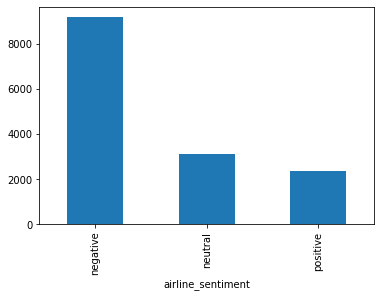

In [26]:
tweets_data.groupby('airline_sentiment').text.count().plot.bar(ylim=0)
plt.show()

### Preprocessing data

In [27]:
#Clean Text by removing user handles, stop words, word less than 3 characters, etc.
# Code from:
# https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
import re

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [28]:
# remove twitter handles (@user)
tweets_data['tidy_tweet'] = np.vectorize(remove_pattern)(tweets_data['text'], "@[\w]*")
# remove special characters, numbers, punctuations
tweets_data['tidy_tweet'] = tweets_data['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
# remove words less than 3 characters long
tweets_data['tidy_tweet'] = tweets_data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
tweets_data['tidy_tweet'] = tweets_data['tidy_tweet'].apply(lambda x:x.lower())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [29]:
tweets_data.head()

,airline_sentiment,text,sentiment_type,tidy_tweet
0,neutral,@VirginAmerica What @dhepburn said.,1,what said
1,positive,@VirginAmerica plus you've added commercials t...,2,plus you added commercials the experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,1,didn today must mean need take another trip
3,negative,@VirginAmerica it's really aggressive to blast...,0,really aggressive blast obnoxious entertainmen...
4,negative,@VirginAmerica and it's a really big bad thing...,0,and really big bad thing about


In [30]:
X=tweets_data['tidy_tweet']
y=tweets_data['sentiment_type']

In [31]:
#One-hot Encoding for airline sentiment
#labels = to_categorical(np.asarray(y))
#labels

In [32]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
#tokenize the text
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(X).toarray()

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score


models = [
    XGBClassifier(),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0,l1_ratio=1),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, processed_features, y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


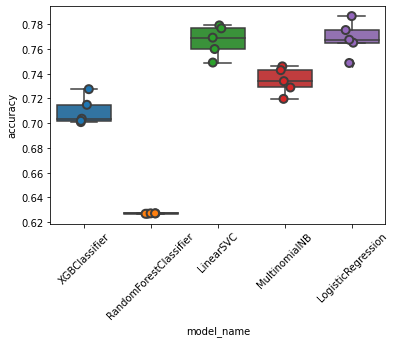

In [35]:
import seaborn as sns

x1=sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
x1.set_xticklabels(x1.get_xticklabels(), rotation=45)
plt.show()

In [36]:
cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

model_name
LogisticRegression        0.768579
LinearSVC                 0.766735
MultinomialNB             0.734221
XGBClassifier             0.709699
RandomForestClassifier    0.626913
Name: accuracy, dtype: float64

### Logistic regression, MultiNomial, Random Forest and XGBoost classifier models are built

##### Model 1: Logistic Regression


In [51]:
model_2 = LogisticRegression(solver='sag', multi_class='multinomial', max_iter=1000, random_state=101,l1_ratio=1) # uses the cross-entropy loss
# train the model
model_2.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=1, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=101, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
y_train_pred = model_2.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_train

0.8409445745511319

In [53]:
y_pred = model_2.predict(X_test)
accuracy_train = accuracy_score(y_test, y_pred)
accuracy_train

0.775728597449909

In [56]:
print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=tweets_data['airline_sentiment'].unique()))
accuracy = accuracy_score(y_test, y_pred)
print('Testing Accuracy: %f' % (accuracy*100))

[[2575  139   46]
 [ 433  428   63]
 [ 206   98  404]]
              precision    recall  f1-score   support

     neutral       0.80      0.93      0.86      2760
    positive       0.64      0.46      0.54       924
    negative       0.79      0.57      0.66       708

    accuracy                           0.78      4392
   macro avg       0.74      0.66      0.69      4392
weighted avg       0.77      0.78      0.76      4392

Testing Accuracy: 77.572860


##### Model 2: Multinomial NB

In [69]:
model_2 = MultinomialNB()
model_2.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [70]:
y_train_pred = model_2.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_train

0.7749804839968775

In [71]:
y_pred = model_2.predict(X_test)
accuracy_train = accuracy_score(y_test, y_pred)
accuracy_train

0.738615664845173

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=tweets_data['airline_sentiment'].unique()))
accuracy = accuracy_score(y_test, y_pred)
print('Testing Accuracy: %f' % (accuracy*100))

##### Model 3: Random Forest  

In [57]:
model_3 = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

In [58]:
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)

In [59]:
y_train_pred = model_3.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_train

0.6262685402029664

In [60]:
y_pred = model_3.predict(X_test)
accuracy_train = accuracy_score(y_test, y_pred)
accuracy_train

0.6284153005464481

In [61]:
print(confusion_matrix(y_test, y_pred))
#print(metrics.classification_report(y_test, y_pred, target_names=tweets_data['airline_sentiment'].unique()))
#accuracy = accuracy_score(y_test, predictions)
#print('Testing Accuracy: %f' % (accuracy*100))

[[2760    0    0]
 [ 924    0    0]
 [ 708    0    0]]


##### Model 4: XGBoost  

In [62]:
model_4 = XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=500, n_jobs=-1)

In [63]:
model_4.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [64]:
y_train_pred = model_4.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_train

0.7256049960967994

In [65]:
y_pred = model_4.predict(X_test)
accuracy_train = accuracy_score(y_test, y_pred)
accuracy_train

0.7092440801457195

In [66]:
print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=tweets_data['airline_sentiment'].unique()))
accuracy = accuracy_score(y_test, y_pred)
print('Testing Accuracy: %f' % (accuracy*100))

[[2651   32   77]
 [ 750  115   59]
 [ 338   21  349]]
              precision    recall  f1-score   support

     neutral       0.71      0.96      0.82      2760
    positive       0.68      0.12      0.21       924
    negative       0.72      0.49      0.59       708

    accuracy                           0.71      4392
   macro avg       0.70      0.53      0.54      4392
weighted avg       0.71      0.71      0.65      4392

Testing Accuracy: 70.924408
